In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image


from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue.draw import sheet_view
from tyssue.generation import three_faces_sheet
from tyssue.draw.plt_draw import plot_forces

from tyssue.dynamics import PlanarModel

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw.plt_draw import create_gif


geom  = SheetGeometry
model = PlanarModel

This notebooks demonstrates usage of the time dependant solver `EulerSolver` in the simplest case where we solve
$$\eta_i \frac{d\mathbf{r}_i}{dt}  = \mathbf{F}_i = - \mathbf{\nabla}_i E$$

The model is defined in the same way it is defined for the quasistatic solver.

## Simple forward Euler solver

$$\mathbf{r}_i(t+dt) = \mathbf{r}_i(t) + \frac{\mathbf{F}_i(t)}{\eta} dt$$


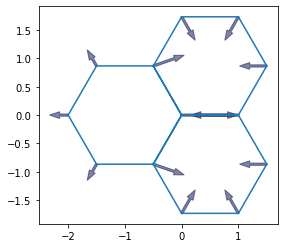

In [34]:
sheet = Sheet('3', *three_faces_sheet())
geom.update_all(sheet)
sheet.settings['threshold_length'] = 1e-3

sheet.update_specs(config.dynamics.quasistatic_plane_spec())
sheet.face_df["prefered_area"] = sheet.face_df["area"].mean()
history = History(sheet) #, extra_cols={"edge":["dx", "dy", "sx", "sy", "tx", "ty"]})

sheet.vert_df['viscosity'] = 1.0
sheet.edge_df.loc[[0, 17],  'line_tension'] *= 4
sheet.face_df.loc[1,  'prefered_area'] *= 1.2

fig, ax = plot_forces(sheet, geom, model, ['x', 'y'], 1)

Solver instanciation

In [35]:
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True)


The solver's `solve` method accepts a `on_topo_change` function as argument. This function is executed each time a topology change occurs. Here, we reste the line tension to its original value.

In [36]:
def on_topo_change(sheet):
    print("reseting tension")
    sheet.edge_df["line_tension"] = sheet.specs["edge"]["line_tension"]


### Solving from $t = 0$ to $t = 15$

In [37]:
res = solver.solve(tf=15, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver.eptm,))

reseting tension
reseting tension


### Showing the results

In [38]:
create_gif(solver.history, "sheet3.gif", num_frames=120)

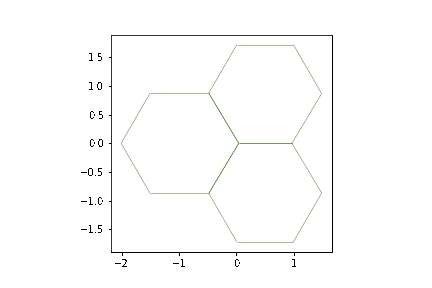

In [39]:
Image("sheet3.gif")


## The  `history` object

The above solver takes an `History` argument. This object is in charge of storing the evolving epithelium during the course of the simulation.


In the solver, we use the `history.record` method to store the epithelium. In the `create_gif` function, we use the `history.retrieve` method to get back the epithelium at a given time point. Please see the API for more details.


In [40]:
print(history.time_stamps)

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.85  3.9   3.95  4.    4.05  4.1   4.15
  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35
  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95
  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35  6.4   6.45  6.5   6.55
  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55  7.6   7.65  7.7   7.75
  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15  8

There is also a `HistoryHDF5` class that writes each time step to a file, which can be usefull for big files.